In [1]:
from IPython.core.display import HTML
display(HTML('<style>.container { width:95% !important; } </style>'))

%load_ext autoreload
%autoreload 2

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from matplotlib.ticker import FuncFormatter

In [3]:
SEED = 123

WALKAWAY = 0
INIT_STATE = 0
assert WALKAWAY == 0
assert INIT_STATE == 0

LEFT = 1
RIGHT = 0

In [4]:
# class GamblingMDP(gym.Env):
#     def __init__(self, probs=[0.5], expected_outcome=-36/38, seed=None):
#         self.probs = probs
#         self.expected_outcome = expected_outcome
        
#         self.nS = 1
#         self.nA = len(probs) + 1
        
#         self.state_space = gym.spaces.Discrete(self.nS)
#         self.action_space = gym.spaces.Discrete(self.nA)
#         self._seed(seed)
#         self.state = None

#     def _seed(self, seed=None):
#         if seed is not None:
#             np.random.seed(seed)

#     def step(self, action):
#         assert self.action_space.contains(action)
#         assert self.state == INIT_STATE
        
#         if action == WALKAWAY:
#             reward = 0.0
#         else:
#             # Each bet has the same average payout and has two outcomes:
#             # loss of -1 (size of the bet) or gain.
#             # Each bet has a different win probability,
#             # and the corresponding gain is calibrated to have the same
#             # expected outcome (like in Roulette).
#             win_gain = -self.expected_outcome / self.probs[action - 1]
#             reward = (win_gain - 1) if np.random.rand() < self.probs[action - 1] else -1

#         done = True

#         return self.state, reward, done, {}

#     def reset(self):
#         self.state = INIT_STATE
#         return self.state

class ToyMDP(gym.Env):
    def __init__(self, mu=-0.5, std=1.0, seed=None):
        self.mu = mu
        self.std = std
        
        self.nS = 4
        self.nA = 2
        
        self.state_space = gym.spaces.Discrete(self.nS)
        self.action_space = gym.spaces.Discrete(self.nA)
        self._seed(seed)
        self.state = None

    def _seed(self, seed=None):
        if seed is not None:
            np.random.seed(seed)

    def step(self, action):
        assert self.action_space.contains(action)
        
        if self.state == INIT_STATE:
            if action == RIGHT:
                reward = 0.0
                done = True
                self.state = 3
            elif action == LEFT:
                reward = 0.0
                done = False
                self.state = 1
#         elif self.state == 1:
#             reward = 0.0
#             done = False
#             self.state = 2
        elif self.state == 1:
            reward = self.mu + self.std * np.random.randn()
            done = True
            self.state = 2
    
        return self.state, reward, done, {}

    def reset(self):
        self.state = INIT_STATE
        return self.state

In [5]:
def randargmax(b, **kw):
    """ a random tie-breaking argmax"""
    return np.argmax(np.random.random(b.shape) * (b == b.max()), **kw)


def Q_learning(env,
               gamma,
               n_episodes, 
               learning_rate_0,
               epsilon_greedy,
               epsilon_greedy_decay_freq,
               epsilon_greedy_decay_factor,
               ):
    """
    env : gym.Env
    MDP
    
    gamma : float
    Discount factor
   
    n_episodes : int
    Number of episodes
    
    learning_rate_0 : float
    Initial learning rate for the TD step.

    epsilon_greedy : float
    Initial probability of random exploration.
    
    epsilon_greedy_freq : int
    Decrease epsilon_greedy every epsilon_greedy_decay episodes.
    
    epsilon_greedy_factor : float
    Decrease epsilon_greedy by (1-epsilon_greedy_factor)%.

    returns:
    -------
    Q_opt : float array, (env.nS, env.nA) size
    Optimal state-action value function on the MDP
    given a discount GAMMA
    Q_opt[state index][action index] = state-action value of that state
    """
    Q_opt = np.zeros((env.nS, env.nA))
    N_visit = np.zeros((env.nS, env.nA))
    rewards = np.zeros(n_episodes)
    
    for episode in range(n_episodes):
        done = False
        state = env.reset()

        if (episode + 1) % epsilon_greedy_decay_freq == 0:
            epsilon_greedy *= epsilon_greedy_decay_factor
        while not done:
            if np.random.rand() < epsilon_greedy:
                action = env.action_space.sample()
            else:
                action = randargmax(Q_opt[state, :])
            
            N_visit[state, action] += 1
            next_state, r, done, _ = env.step(action)
            
            rewards[episode] = r
        
            pred = Q_opt[state, action]
            target = r + gamma * np.max(Q_opt[next_state, :])
            Q_opt[state, action] = Q_opt[state, action] + learning_rate_0 / N_visit[state, action]  * (target - pred)
            # Move on to next state
            state = next_state

    return Q_opt, rewards

In [6]:
# probs = np.random.uniform(low=1/37, high=18/38, size=10)
# env = GamblingMDP(probs=probs, expected_outcome=-0.5, seed=SEED)
env = ToyMDP(mu=-0.1, std=1.0, seed=SEED)

gamma = 1.0
n_episodes = 500
learning_rate_0 = 1.0
epsilon_greedy = 0.1
epsilon_greedy_decay_freq = 100
epsilon_greedy_decay_factor = 0.1

n_sim = 1000

In [7]:
stats_Q = np.zeros(n_sim)
rewards_Q = np.zeros((n_sim, n_episodes))

for i in tqdm(range(n_sim)):
    Q_opt_Q_learning, rewards = Q_learning(
        env,
        gamma,
        n_episodes,
        learning_rate_0,
        epsilon_greedy,
        epsilon_greedy_decay_freq,
        epsilon_greedy_decay_factor,
    )

    pi_opt_Q_learning = np.argmax(Q_opt_Q_learning, axis=1)
    stats_Q[i] = pi_opt_Q_learning[INIT_STATE]
    rewards_Q[i] = rewards

In [8]:
def Double_Q_learning(env,
                      gamma,
                      n_episodes, 
                      learning_rate_0,
                      epsilon_greedy,
                      epsilon_greedy_decay_freq,
                      epsilon_greedy_decay_factor,
                      ):
    """
    env : gym.Env
    MDP
    
    gamma : float
    Discount factor
   
    n_episodes : int
    Number of episodes
    
    learning_rate_0 : float
    Initial learning rate for the TD step.

    epsilon_greedy : float
    Initial probability of random exploration.
    
    epsilon_greedy_freq : int
    Decrease epsilon_greedy every epsilon_greedy_decay episodes.
    
    epsilon_greedy_factor : float
    Decrease epsilon_greedy by (1-epsilon_greedy_factor)%.

    returns:
    -------
    Q_opt : float array, (env.nS, env.nA) size
    Optimal state-action value function on the MDP
    given a discount GAMMA
    Q_opt[state index][action index] = state-action value of that state
    """
    Q_opt_A = np.zeros((env.nS, env.nA))
    Q_opt_B = np.zeros((env.nS, env.nA))
    Q_opt = np.zeros((env.nS, env.nA))
    
    N_visit_A = np.zeros((env.nS, env.nA))
    N_visit_B = np.zeros((env.nS, env.nA))
    
    rewards = np.zeros(n_episodes)
        
    for episode in range(n_episodes):
        done = False
        state = env.reset()

        if (episode + 1) % epsilon_greedy_decay_freq == 0:
            epsilon_greedy *= epsilon_greedy_decay_factor
        while not done:
            # epsilon-greedy exploration 
            if np.random.rand() < epsilon_greedy:
                action = env.action_space.sample()
            else:
                action = randargmax(Q_opt[state, :])

            next_state, r, done, _ = env.step(action)

            rewards[episode] = r

            update_A = np.random.rand() < 0.5
            if update_A:
                N_visit_A[state, action] += 1
                action_star = randargmax(Q_opt_A[next_state, :])
                pred = Q_opt_A[state, action]
                target = r + gamma * Q_opt_B[next_state, action_star]
                Q_opt_A[state, action] = Q_opt_A[state, action] + learning_rate_0 / N_visit_A[state, action] * (target - pred)
            else:
                N_visit_B[state, action] += 1
                action_star = randargmax(Q_opt_B[next_state, :])
                pred = Q_opt_B[state, action]
                target = r + gamma * Q_opt_A[next_state, action_star]
                Q_opt_B[state, action] = Q_opt_B[state, action] + learning_rate_0 / N_visit_B[state, action] * (target - pred)

            Q_opt[state, action] = 0.5 * (Q_opt_A[state, action] + Q_opt_B[state, action])

            # Move on to next state
            state = next_state

    return Q_opt, rewards

In [9]:
stats_DQ = np.zeros(n_sim)
rewards_DQ = np.zeros((n_sim, n_episodes))

for i in tqdm(range(n_sim)):
    Q_opt_DQ_learning, rewards = Double_Q_learning(
        env,
        gamma,
        n_episodes,
        learning_rate_0,
        epsilon_greedy,
        epsilon_greedy_decay_freq,
        epsilon_greedy_decay_factor,
    )

    pi_opt_DQ_learning = np.argmax(Q_opt_DQ_learning, axis=1)
    rewards_DQ[i] = rewards
    stats_DQ[i] = pi_opt_DQ_learning[INIT_STATE]

RIGHT is the recommended policy by Q-Learning 89% of the time
RIGHT is the recommended policy Double Q-Learning 98% of the time


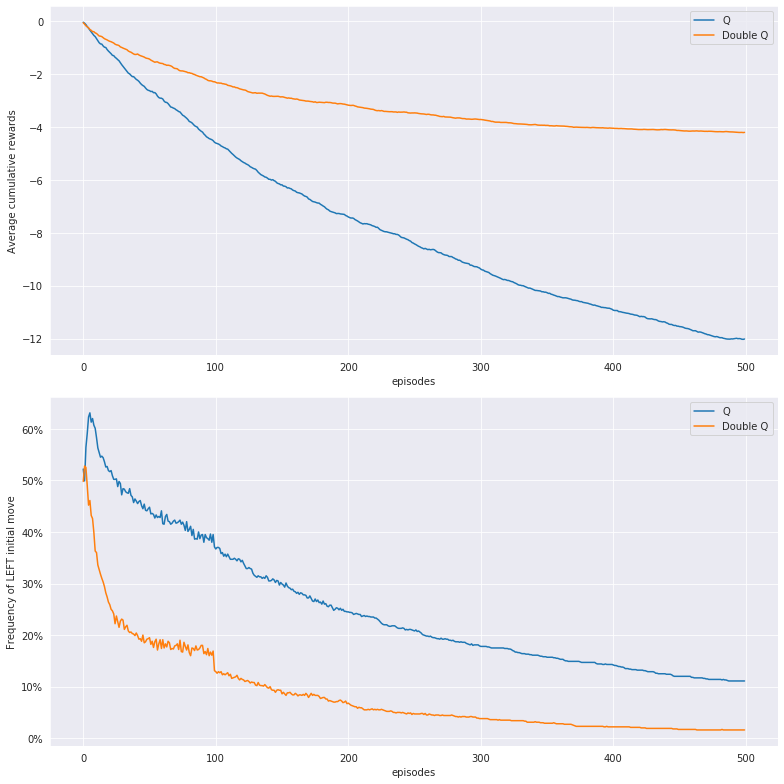

In [10]:
# print('WALKAWAY is the recommended policy by Q-Learning {:.0%} of the time'.format(np.mean(stats_Q == WALKAWAY)))
# print('WALKAWAY is the recommended policy Double Q-Learning {:.0%} of the time'.format(np.mean(stats_DQ == WALKAWAY)))

print('RIGHT is the recommended policy by Q-Learning {:.0%} of the time'.format(np.mean(stats_Q == RIGHT)))
print('RIGHT is the recommended policy Double Q-Learning {:.0%} of the time'.format(np.mean(stats_DQ == RIGHT)))

with sns.axes_style('darkgrid'):
    fig, axes = plt.subplots(figsize=(11, 11), nrows=2, ncols=1)
    
    ax = axes[0]
    ax.plot(np.cumsum(np.mean(rewards_Q, axis=0)), label='Q')
    ax.plot(np.cumsum(np.mean(rewards_DQ, axis=0)), label='Double Q')
    ax.set_xlabel('episodes')
    ax.set_ylabel('Average cumulative rewards')
    ax.legend(loc='upper right')
    
    ax = axes[1]
    ax.plot(np.mean(rewards_Q != 0, axis=0), label='Q')
    ax.plot(np.mean(rewards_DQ != 0, axis=0), label='Double Q')
    ax.set_xlabel('episodes')
    ax.set_ylabel('Frequency of LEFT initial move')
    ax.legend(loc='upper right')
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    
    plt.tight_layout()
    plt.show()